<a href="https://www.kaggle.com/code/avikumart/regression-sales-prediction-sklearn-statsmodels?scriptVersionId=106556583" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction:


**In this notebook, I have built sales prediction models using sci-kit learn and statsmodels libraries to predict sales price of store sales data.**

**I have mentioned various regression metrics to measure performance of regression models with their applications.**

# Table of contents:

1) **[Descriptive and exploratory analysis](#dea)**

2) **[Train and test data preparation](#dataprep)**

3) **[Feature engineering](#fe)**

4) **[Model development and evaluation](#model)**

**[Residual analysis](#resid)**

**[Test of Homoscedasticity](#test)**

**[Outlier analysis](#out)**

**[Leverage values](#lv)**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from xgboost import XGBRegressor
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
df_sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
df_sub = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')


def df_head(df):
    return df.head()

    
df_head(df_sales)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_head(df_sub)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [4]:
df_head(df_items)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df_head(df_shops)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
df_head(df_test)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Descriptive and exploratory data analysis

<a id="dea"></a>

In [7]:
df_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [8]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


In [9]:
df_sales['item_price']

0           999.00
1           899.00
2           899.00
3          1709.05
4          1099.00
            ...   
2935844     299.00
2935845     299.00
2935846     349.00
2935847     299.00
2935848     299.00
Name: item_price, Length: 2935849, dtype: float64

In [10]:
df_sales[['shop_id','item_id','item_price','item_cnt_day']].corr()

,shop_id,item_id,item_price,item_cnt_day
shop_id,1.000000,0.029396,-0.024034,-0.005230
item_id,0.029396,1.000000,-0.134104,0.016650
item_price,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,-0.005230,0.016650,0.011197,1.000000


In [11]:
df_items.describe().T

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


<function matplotlib.pyplot.show(close=None, block=None)>

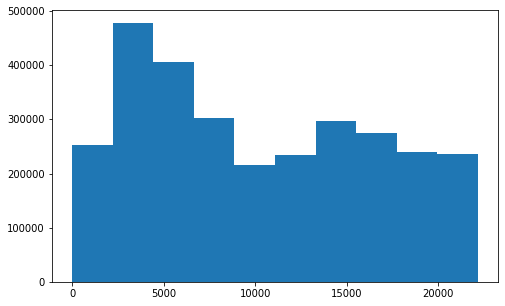

In [12]:
plt.figure(figsize=(8,5))
plt.hist(df_sales['item_id'])
plt.show

> Distribution of item id

<function matplotlib.pyplot.show(close=None, block=None)>

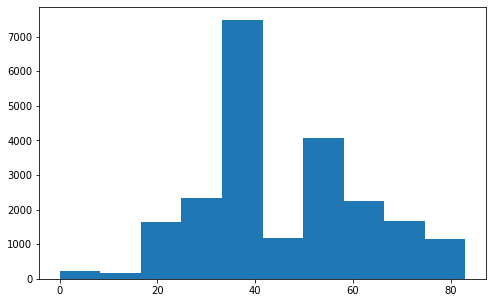

In [13]:
plt.figure(figsize=(8,5))
plt.hist(df_items['item_category_id'])
plt.show

> Distribution of item categories id

<function matplotlib.pyplot.show(close=None, block=None)>

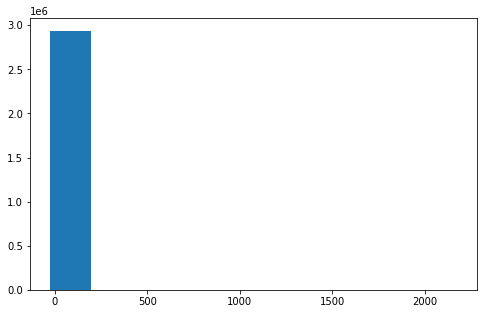

In [14]:
plt.figure(figsize=(8,5))
plt.hist(df_sales['item_cnt_day'])
plt.show

In [15]:
df_items.groupby('item_category_id').count()

,item_name,item_id
item_category_id,,
0,4,4
1,2,2
2,75,75
3,34,34
4,15,15
...,...,...
79,1,1
80,6,6
81,7,7


In [16]:
df_items.groupby('item_category_id').mean()

,item_id
item_category_id,
0,13552.250000
1,5673.000000
2,7434.800000
3,6113.705882
4,4969.066667
...,...
79,17717.000000
80,9249.000000
81,13351.857143


In [17]:
df_items['diff_col_of_item_id'] = df_items.groupby('item_category_id')['item_id'].max() - df_items.groupby('item_category_id')['item_id'].min()

df_items.head()

,item_name,item_id,item_category_id,diff_col_of_item_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,10816.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,134.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7966.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7419.0
4,***КОРОБКА (СТЕКЛО) D,4,40,11147.0


In [18]:
#df_items.drop('diff_col', inplace=True, axis=1)
#df_items

In [19]:
df_items.head()

,item_name,item_id,item_category_id,diff_col_of_item_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,10816.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,134.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7966.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7419.0
4,***КОРОБКА (СТЕКЛО) D,4,40,11147.0


> What we have found so far:

1. item id and shop id will be only independent variable will predict target variable
2. we will drop item price column from train data set
3. shop ids are between 1 t0 60
4. item id and item price are correlate with each other
5. each item id fall into certain item category as item ids >> item category
6. we can assign new column item_category to each item id

# Train and test data set preparation and pre-processing

<a id="dataprep"></a>

In [20]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [21]:
df_sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [22]:
df_sales.drop_duplicates(keep='first', inplace=True, ignore_index=True)

df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [23]:
df_sales[df_sales['item_price'] <0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,15.05.2013,4,32,2973,-1.0,1.0


In [24]:
df_sales.drop(df_sales[df_sales['item_cnt_day'] <0].index , inplace=True)
df_sales.drop(df_sales[df_sales['item_price'] <0].index , inplace=True)

df_sales.shape

(2928486, 6)

## outliers removal

In [25]:
Q1 = np.percentile(df_sales['item_price'], 25.0)
Q3 = np.percentile(df_sales['item_price'], 75.0)

IQR = Q3 - Q1

df_sub1 = df_sales[df_sales['item_price'] > Q3 + 1.5*IQR]
df_sub2 = df_sales[df_sales['item_price'] < Q1 - 1.5*IQR]

df_sales.drop(df_sub1.index, inplace=True)

df_sales.shape

(2670931, 6)

In [26]:
df_sales['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [27]:
df_sales.groupby('date_block_num')['item_id'].mean()

date_block_num
0     10437.874241
1     10094.739024
2     10272.665975
3     10491.197571
4     10453.088679
5     10453.211951
6     10646.363618
7     10215.190504
8     10175.876895
9     10614.346861
10    10589.980521
11    10410.177452
12    10392.215130
13     9976.254429
14    10535.516754
15    10861.633872
16    10571.830409
17    10490.160861
18    10484.988244
19    10369.118885
20    10556.140961
21    10772.814302
22    10682.868015
23    10822.272561
24    10743.796818
25    10853.609323
26    11017.415613
27    11087.856680
28    10718.165604
29    10674.438441
30    11002.175358
31    10389.431964
32    10447.862064
33    11430.368451
Name: item_id, dtype: float64

In [28]:
price = round(np.array(df_sales.groupby('date_block_num')['item_price'].mean()).mean(),2)
print(price)

573.36


In [29]:
dict(round(df_sales.groupby('date_block_num')['item_price'].mean(),4))

{0: 523.3136,
 1: 530.6769,
 2: 515.1063,
 3: 507.681,
 4: 500.4043,
 5: 483.6083,
 6: 475.9361,
 7: 485.0816,
 8: 530.7074,
 9: 526.2786,
 10: 553.5716,
 11: 598.0684,
 12: 560.4089,
 13: 558.7864,
 14: 548.9686,
 15: 537.6172,
 16: 527.4048,
 17: 519.3315,
 18: 525.0034,
 19: 548.2421,
 20: 606.8177,
 21: 618.6799,
 22: 611.0263,
 23: 687.4857,
 24: 646.9772,
 25: 628.1663,
 26: 611.3147,
 27: 617.0509,
 28: 660.2883,
 29: 664.2991,
 30: 634.8502,
 31: 635.9069,
 32: 657.6738,
 33: 657.6354}

In [30]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [31]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Feature engineering

<a id="fe"></a>

#### FE workflow

> create columns with mean price by date block in train and test dataset, remove item price from train

> remove data_ block column from train data set

> create new cloumns with mean price per shop id for both train and test dataset

> merge df_items table with train and test dataset on item id and create new column item category


In [32]:
#df_sales.drop('mean_price_data_block', inplace=True, axis=1)

replace_dict = dict(round(df_sales.groupby('date_block_num')['item_price'].mean(),2))

In [33]:
df_sales['date_block_num'] = df_sales['date_block_num'].replace(replace_dict)

df_train = df_sales.copy()
df_train.drop(['date','item_price'], axis=1, inplace=True)
df_train.rename(columns = {'date_block_num':'mean_price_by_column'}, inplace=True)
df_train.head()

,mean_price_by_column,shop_id,item_id,item_cnt_day
0,523.31,59,22154,1.0
1,523.31,25,2552,1.0
3,523.31,25,2554,1.0
4,523.31,25,2555,1.0
5,523.31,25,2564,1.0


In [34]:
mean_price = np.array(df_sales.groupby('date_block_num')['item_price'].mean()).mean()
mean_price

573.3638104404596

In [35]:
df_test.shape

(214200, 3)

In [36]:
df_train.shape

(2670931, 4)

In [37]:
#df_test.drop('ID', inplace=True, axis=1)
df_test.head()
com_df = pd.concat([df_train,df_test])

com_df['mean_price_by_column'] = com_df['mean_price_by_column'].fillna(value=price)
com_df['item_cnt_day'] = com_df['item_cnt_day'].fillna(value=0)

test_df = com_df[com_df['item_cnt_day'] == 0]
train_df = com_df[com_df['item_cnt_day'] != 0]

In [38]:
test_df.shape

(214200, 5)

In [39]:
testdf = test_df.copy()

testdf.drop('ID', inplace=True, axis=1)
testdf.drop('item_cnt_day', inplace=True, axis=1)
testdf

,mean_price_by_column,shop_id,item_id
0,573.36,5,5037
1,573.36,5,5320
2,573.36,5,5233
3,573.36,5,5232
4,573.36,5,5268
...,...,...,...
214195,573.36,45,18454
214196,573.36,45,16188
214197,573.36,45,15757
214198,573.36,45,19648


In [40]:
traindf = train_df.copy()

traindf.drop('ID', inplace=True, axis=1)

In [41]:
traindf.head()

,mean_price_by_column,shop_id,item_id,item_cnt_day
0,523.31,59,22154,1.0
1,523.31,25,2552,1.0
3,523.31,25,2554,1.0
4,523.31,25,2555,1.0
5,523.31,25,2564,1.0


# Train data and test data for modelling and evalution

<a id="model"></a>

In [42]:
#test_df.drop('item_cnt_day', inplace=True, axis=1)
testdf['item_id'] = (testdf['item_id'] - testdf['item_id'].mean())/testdf['item_id'].std()
testdf.head()

,mean_price_by_column,shop_id,item_id
0,573.36,5,-0.956779
1,573.36,5,-0.911518
2,573.36,5,-0.925432
3,573.36,5,-0.925592
4,573.36,5,-0.919835


In [43]:
traindf['item_id'] = (traindf['item_id'] - traindf['item_id'].mean())/traindf['item_id'].std()
traindf.head()

,mean_price_by_column,shop_id,item_id,item_cnt_day
0,523.31,59,1.830655,1.0
1,523.31,25,-1.258324,1.0
3,523.31,25,-1.258009,1.0
4,523.31,25,-1.257852,1.0
5,523.31,25,-1.256433,1.0


# Model 1 

In [44]:
X = traindf.loc[:,['mean_price_by_column','shop_id','item_id']]
y = traindf.loc[:,'item_cnt_day']

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8, random_state= 42)

model1 = LinearRegression()

model1.fit(X_train,y_train)

print("regression coefficients are: " , model1.coef_)

y_pred = model1.predict(X_valid)


MSE = mean_squared_error(y_valid,y_pred)
MAE = mean_absolute_error(y_valid,y_pred)
R2  = r2_score(y_valid,y_pred)

print("MSE: ", MSE)
print("MAE: ", MAE)
print("R2: ", R2)

regression coefficients are:  [ 0.00052884 -0.00073067  0.06059091]
MSE:  3.568506908593113
MAE:  0.4151444070506008
R2:  0.001130854051605401


In [46]:
#model_sub_pred = model1.predict(testdf)

#sub_df = pd.DataFrame(data= {'ID':np.array(df_test['ID']),'item_cnt_month':model_sub_pred})

#sub_df.to_csv('submission.csv', index=False)

# Model 2

In [47]:
# addding constant as statsmodels api does not include it!
X_new = X.copy()
X_new = sm.add_constant(X_new)
test_df_new = test_df.copy()
test_df_new = sm.add_constant(test_df_new)
X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(X_new, y,train_size=0.8, random_state= 42)

In [48]:
#using statsmodel api

stats_model = sm.OLS(y_train_new, X_train_new)
stat_fit = stats_model.fit()
print("Model coeffieciants: ", stat_fit.params)

print("\nModel summary: ", stat_fit.summary2())

Model coeffieciants:  const                   0.956325
mean_price_by_column    0.000529
shop_id                -0.000731
item_id                 0.060591
dtype: float64

Model summary:                     Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.001        
Dependent Variable: item_cnt_day     AIC:                10379178.5089
Date:               2022-09-26 10:53 BIC:                10379228.8081
No. Observations:   2136744          Log-Likelihood:     -5.1896e+06  
Df Model:           3                F-statistic:        458.9        
Df Residuals:       2136740          Prob (F-statistic): 4.14e-298    
R-squared:          0.001            Scale:              7.5353       
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                   0.9563   0.0183 52.3667 0.000

> P value is less than 0.05 indicates that model is statistically significant

> F-stat is also very low

> R2 is almost 17%, that explains independent variables explain 17% of variation in dependent variable item count

## Residual analysis

<a id="resid"></a>

<Figure size 576x576 with 0 Axes>

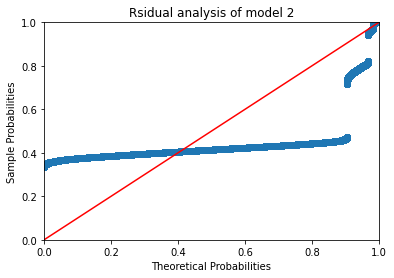

In [49]:
model_residual = stat_fit.resid
probplot = sm.ProbPlot(model_residual)
plt.figure(figsize=(8,8))
probplot.ppplot(line = '45')
plt.title("Rsidual analysis of model 2")
plt.show()

> theoritical probabilties and sample probabilities are not corellating with each other, it implies that resdiuls are not folloewing normal distribution.

> model is not a good fit to data as data is polynomial.

## Test of Homoscedasticity

<a id="test"></a>

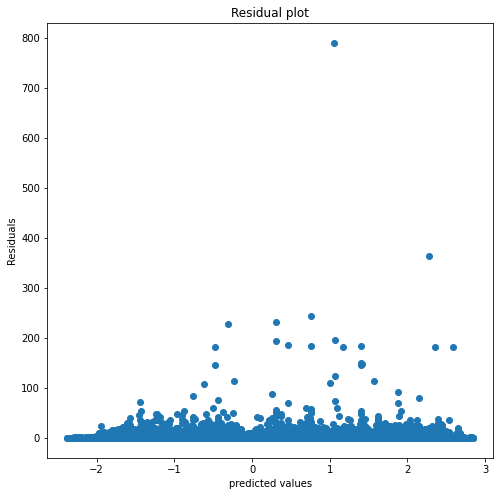

In [50]:
def get_std_val(vals):
    return (vals - vals.mean())/vals.std()

plt.figure(figsize=(8,8))
plt.scatter(get_std_val(stat_fit.fittedvalues), get_std_val(model_residual))
plt.title("Residual plot")
plt.xlabel("predicted values")
plt.ylabel("Residuals")
plt.show()

> There is a clear funnel shape is observed and we can see that there is couple of outliers in actual values of y.

## Outlier analysis

<a id="out"></a>

In [51]:
traindf['z_score_item'] = zscore(traindf['item_cnt_day'])

In [52]:
#outliears in y variable

traindf[(traindf['z_score_item'] > 3.0) | (traindf['z_score_item'] < -3.0)]

,mean_price_by_column,shop_id,item_id,item_cnt_day,z_score_item
404,523.31,25,-1.192139,13.0,4.531269
4173,523.31,25,0.642150,10.0,3.376277
4230,523.31,25,0.443908,10.0,3.376277
5410,523.31,25,0.931791,11.0,3.761274
5415,523.31,25,0.931791,10.0,3.376277
...,...,...,...,...,...
2935356,657.64,25,-0.052957,79.0,29.941082
2935357,657.64,25,-0.052957,26.0,9.536232
2935358,657.64,25,-0.052957,17.0,6.071257
2935371,657.64,25,-0.052800,34.0,12.616209


> Total 9971 rows are having extream item sales which resulted in higher residuals

## Cook's distance


In [53]:
#item_influence = stat_fit.get_influence()
#(c, p) = item_influence.cooks_distance

#plt.stem(np.arange(len(X_train)),
   #      np.round(c, 3),
     #    markerfmt=',')
#plt.title("Cook's distance")
#plt.xlabel("row index")
#plt.ylabel('Cook\'s distance')
#plt.show

> Using influence method we can plot cooks distance to find which observance has a most influence on output variable

## Leverage Values

<a id='lv'></a>

In [54]:
#fig, ax = plt.subplots(figsize=(8,6))
#influence_plot(stat_fit, ax=ax)
#plt.title("Influence plot")
#plt.show()

In [55]:
pred_y = stat_fit.predict(X_valid_new)

r2 = r2_score(y_valid_new,pred_y)
mse = mean_squared_error(y_valid_new,pred_y)
mae = mean_absolute_error(y_valid_new,pred_y)

print(r2)
print(mse)
print(mae)

0.001130854051605401
3.568506908593113
0.41514440705059985


In [56]:
#model_sub = stat_fit.predict(testdf)

#sub_dff = pd.DataFrame(data= {'ID':np.array(df_test['ID']),'item_cnt_month':model_sub})

#sub_dff.to_csv('submission.csv', index=False) 

## Calculating prediction intervals

In [57]:
pred_y = stat_fit.predict(X_valid_new)

_, pred_y_low, pred_y_high = wls_prediction_std( stat_fit, 
                                                X_valid_new, 
                                                alpha = 0.1)

pred_int_df = pd.DataFrame({'item_id_z': X_valid['item_id'],
                            'pred_y': np.array(pred_y),
                            'Pred_y_low': pred_y_low,
                             'Pred_y_high': pred_y_high
                           })

pred_int_df.head(10)

,item_id_z,pred_y,Pred_y_low,Pred_y_high
1639019,0.706917,1.256877,-3.258325,5.772078
1419572,-0.636809,1.175254,-3.339949,5.690456
180841,-0.197778,1.224984,-3.290221,5.740190
1331662,-1.152427,1.174095,-3.341108,5.689299
2212173,-0.023331,1.276833,-3.238374,5.792040
591709,-0.658714,1.158281,-3.356923,5.673484
2712400,-0.887212,1.218071,-3.297134,5.733277
1357003,-1.074896,1.167833,-3.347369,5.683035
1912851,-0.703468,1.190478,-3.324724,5.705681
1409186,-0.413669,1.210694,-3.304507,5.725895


> Using statsmodels wls_prediction_std method we have calculated prediction interval for each predicted  value of y.

# Model 3

In [58]:
model3 = XGBRegressor(n_estimators=50,
                      max_depth=3,
                      learning_rate = 0.01)

model3.fit(X_train, y_train)

prey = model3.predict(X_valid)

sq_error = mean_squared_error(y_valid, prey)

print(sq_error)

3.56014920300623


In [59]:
model3_sub = model3.predict(testdf)

sub_dff2 = pd.DataFrame(data= {'ID':np.array(df_test['ID']),'item_cnt_month':model3_sub})

sub_dff2.to_csv('submission.csv', index=False) 

## **If you liked this notebook, Do upvote and share your feedback on the same**